In [0]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.metrics import confusion_matrix

#### Start of Google - Colaboratory setup 
1. Auth setup
2. Keras install, check for GPU usage etc.
2. GCP Bucket - files download

In [7]:
!pip install keras
from keras.models import load_model

Using TensorFlow backend.


In [10]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import auth
auth.authenticate_user()

In [6]:
# specify your project ID here, which is in your GCP account
project_id = '...'
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
bucket_name = 'dse_capstone_luna16'
model_file = 'cnn_3d_64_64_3_HOLDOUT5_20180301_210933.hdf5'

# model_file = 'cnn_3d_64_64_3_HOLDOUT1_20180227_185500.hdf5'
# model_file = 'cnn_3d_64_64_3_HOLDOUT3_20180301_231003.hdf5'
# model_file = 'cnn_3d_64_64_3_HOLDOUT9_20180301_143310.hdf5'

HOLDOUT=5

In [ ]:
%%time
!gsutil cp gs://{'dse_capstone_luna16/LUNA16/model-files'}/{model_file}  .

In [0]:
# %%time
# !gsutil cp gs://{'dse_capstone_luna16/LUNA16/hdf5-files'}/64x64x3-patch.hdf5 .

#### End of Google - Colaboratory setup 

In [17]:
%%time
# HOLDOUT=9
model = load_model(model_file)

CPU times: user 10.3 s, sys: 878 ms, total: 11.2 s
Wall time: 11.1 s


In [18]:
%%time
df = h5py.File("64x64x3-patch.hdf5", "r")
idx_subset = np.where(df["subsets"][:,0] == HOLDOUT)[0]

CPU times: user 11.7 s, sys: 13.5 s, total: 25.3 s
Wall time: 3min 44s


In [19]:
%%time
imgs = df["input"][idx_subset, :]
imgs_reshaped = imgs.reshape(len(idx_subset), 3, 64, 64, 1).swapaxes(1,3)

CPU times: user 5.29 s, sys: 3.78 s, total: 9.07 s
Wall time: 18.2 s


In [20]:
%%time
predictions = model.predict(imgs_reshaped, verbose=2)

CPU times: user 30.2 s, sys: 6.27 s, total: 36.5 s
Wall time: 3min 7s


In [21]:
y_true = df["output"][idx_subset, :]
confusion_matrix(y_true, np.round(predictions))

array([[75438,   126],
       [   40,    87]])

In [22]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

print("Recall = {}".format(recall_score(y_true, np.round(predictions))))
print("Precision = {}".format(precision_score(y_true, np.round(predictions))))
print("AUC = {}".format(roc_auc_score(y_true, predictions)))
      

Recall = 0.6850393700787402
Precision = 0.4084507042253521
AUC = 0.946270606717276


In [23]:
from sklearn.metrics import average_precision_score

average_precision_score(y_true, predictions)

0.5946926967563801

In [0]:
from sklearn.metrics import roc_curve, auc
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

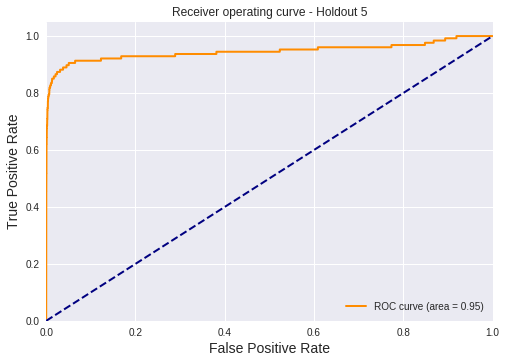

In [25]:
import seaborn as sns
sns.set()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating curve - Holdout {}'.format(HOLDOUT))
plt.legend(loc="lower right")
plt.show()

In [0]:
d = np.array([predictions, y_true])

In [0]:
dfp = pd.DataFrame(d[:,:,0].transpose())
dfp.columns = ["Prediction", "Truth"]

In [0]:
dfp.to_csv("gcb_predictions_truth_subset{}.csv".format(HOLDOUT))

In [0]:
#dfp

In [0]:
df_out = pd.DataFrame((df["uuid"][idx_subset,:]).astype(str))
df_out.columns = ["seriesuid"]

df_out["coordX"] = df["centroid"][idx_subset, 0]
df_out["coordY"] = df["centroid"][idx_subset, 1]
df_out["coordZ"] = df["centroid"][idx_subset, 2]

In [0]:
df_out["probability"] = dfp["Prediction"]

In [0]:
# df_out

In [0]:
df_out.to_csv("gcb_predictions_subset{}.csv".format(HOLDOUT), index=False)

In [34]:
!gsutil cp gcb_predictions_subset{HOLDOUT}.csv  gs://{bucket_name}/LUNA16/predictions-files/  
!gsutil cp gcb_predictions_truth_subset{HOLDOUT}.csv  gs://{bucket_name}/LUNA16/predictions-files

Copying file://gcb_predictions_subset5.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/9.1 MiB.                                      
Copying file://gcb_predictions_truth_subset5.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/2.3 MiB.                                      
